### Imports

In [1]:
import json
import os
import random
from typing import Literal, Sequence

import matplotlib.pyplot as plt
import numpy as np
import torch
from pydantic import BaseModel, ConfigDict
from torch import nn
from torch.utils.data import DataLoader

from careamics.config import InferenceConfig
from careamics.config import (
    VAEAlgorithmConfig,
    TrainingConfig,
    DataConfig,
)
from careamics.dataset import InMemoryTiledPredDataset
from careamics.dataset.dataset_utils.readers import load_astro_neuron_data
from careamics.dataset.tiling import collate_tiles
from careamics.lightning import VAEModule
from careamics.utils.io_utils import load_config, load_model_checkpoint

In [2]:
class ExtraLambdaParameters(BaseModel):
    model_config = ConfigDict(
        validate_assignment=True, validate_default=True, extra="allow"
    )
    dset_type: Literal["astrocytes", "neurons"]
    """The type of dataset to use."""
    img_type : Literal["raw", "unmixed"]
    """The type of image to load, i.e., either raw multispectral or unmixed stacks."""
    groups : Sequence[Literal["control", "arsenite", "tharps"]]
    """The groups of samples to load."""
    dim : Literal["2D", "3D"] = "2D"
    """The dimensionality of the images to load."""

In [3]:
def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

### Set Evaluation Parameters

In [4]:
DATA_ROOT = "/group/jug/federico/data/neurons_and_astrocytes"
OUT_ROOT = "/group/jug/federico/lambdasplit_training/"

In [5]:
ckpt_dir = os.path.join(OUT_ROOT, "2411/lambdasplit_astro/0")
assert os.path.exists(ckpt_dir)

In [6]:
# Eval Parameters
mmse_count: int = 10
"""The number of predictions to average for MMSE evaluation."""
tile_size: list[int] = [64, 64]
"""The size of the portion of image we retain from inner padding/tiling."""
tile_overlap: list[int] = [32, 32]
"""The actual patch size. If not specified data.image_size."""
psnr_type: Literal['simple', 'range_invariant'] = 'range_invariant'
"""The type of PSNR to compute."""
which_ckpt: Literal['best', 'last'] = 'best'
"""Which checkpoint to use for evaluation."""

'Which checkpoint to use for evaluation.'

In [7]:
# Optional other params
batch_size: int = 32
"""The batch size for training."""
num_workers: int = 4
"""The number of workers to use for data loading."""

'The number of workers to use for data loading.'

### 1. Load configs

In [8]:
if os.path.isdir(ckpt_dir):
    algo_config = VAEAlgorithmConfig(**load_config(ckpt_dir, "algorithm"))
    training_config = TrainingConfig(**load_config(ckpt_dir, "training"))
    data_config = DataConfig(**load_config(ckpt_dir, "data"))
    with open(os.path.join(ckpt_dir, "lambda_params.json"), "r") as f:
        lambda_params = ExtraLambdaParameters(**json.load(f))

In [9]:
algo_config.model.fluorophores

['BODIPY 650_665', 'mApple', 'mOrange2', 'Venus', 'avGFP', 'mTurquoise']

### 2. Load dataset

`InMemoryTiledPredDataset` class does not allow to pass file names as input, since it doesn't provide a read file functionality. We therefore need to first load and store data into an array.

Moreover, it requires an `InferenceConfig` config as input.

In [10]:
pred_config = InferenceConfig(
    data_type="array",
    tile_size=tile_size,
    tile_overlap=tile_overlap,
    batch_size=batch_size,
    axes="SCYX",
    image_means=data_config.image_means,
    image_stds=data_config.image_stds,
    tta_transforms=False
)

In [11]:
# NOTE: entire dset used for evaluation
input_data = load_astro_neuron_data(
    data_path=DATA_ROOT,
    dset_type=lambda_params.dset_type,
    img_type=lambda_params.img_type,
    groups=lambda_params.groups,
    dim=lambda_params.dim,
)

Dataset: astrocytes -- raw -- ['CONTROL'] -- 2D
Found 30 images.


Loading images: 100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


In [12]:
val_dset = InMemoryTiledPredDataset(
    prediction_config=pred_config,
    inputs=input_data[:5],
)
del input_data

In [13]:
val_dloader = DataLoader(
    val_dset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_tiles
)

In [14]:
data_mean = data_config.image_means
data_std = data_config.image_stds

##### GT dataset (unmixed images)

In [26]:
gt_data = load_astro_neuron_data(
    data_path=DATA_ROOT,
    dset_type=lambda_params.dset_type,
    img_type="unmixed",
    groups=lambda_params.groups,
    dim=lambda_params.dim,
)

Dataset: astrocytes -- unmixed -- ['CONTROL'] -- 2D
Found 30 images.


Loading images: 100%|██████████| 30/30 [00:00<00:00, 84.11it/s]


In [27]:
gt_data = gt_data[:5]

In [17]:
gt_data = gt_data[:5]
del gt_data

### 3. Create model

Note: noise model and the associated likelihood are not saved in the config, hence we need to reinitialize them.

In [18]:
light_model = VAEModule(algorithm_config=algo_config)

[GaussianLikelihood] PredLVar:None LowBLVar:-5.0


In [19]:
checkpoint = load_model_checkpoint(ckpt_dir, which_ckpt)
light_model.load_state_dict(checkpoint['state_dict'], strict=False)
light_model.eval()
light_model.cuda()

print('Loading weights from epoch', checkpoint['epoch'])

Loading checkpoint from: '/group/jug/federico/lambdasplit_training/2411/lambdasplit_astro/0/best-epoch=229.ckpt'
Loading weights from epoch 229


In [20]:
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in light_model.parameters() if p.requires_grad)

print(f'Model has {count_parameters(light_model)/1000_000:.3f}M parameters')

Model has 3.008M parameters


### 4. Evaluation

In [21]:
from careamics.utils.eval_utils import get_tiled_predictions
from careamics.prediction_utils import stitch_prediction
from careamics.utils.visualization import intensity_histograms, plot_splitting_results, view3D

#### 4.1. Get predictions for patches

In [22]:
pred_patches, pred_stds, rec_patches, tiles_info = get_tiled_predictions(light_model, val_dloader, mmse_count)

Predicting patches: 100%|██████████| 423/423 [02:57<00:00,  2.38it/s]


In [23]:
print(pred_patches.shape, pred_stds.shape, rec_patches.shape, len(tiles_info))

(13520, 6, 64, 64) (13520, 6, 64, 64) (13520, 28, 64, 64) 13520


#### 4.2. Get full image predictions by stitching the predicted tiles

In [24]:
pred_imgs = np.concatenate(stitch_prediction(pred_patches, tiles_info))
del pred_patches
pred_std_imgs = np.concatenate(stitch_prediction(pred_stds, tiles_info))
del pred_stds
rec_imgs = np.concatenate(stitch_prediction(rec_patches, tiles_info))
del rec_patches

#### 4.3. Visualize some of the results

In [30]:
pred_imgs.shape, pred_std_imgs.shape, rec_imgs.shape

((5, 6, 1688, 1688), (5, 6, 1688, 1688), (5, 28, 1688, 1688))

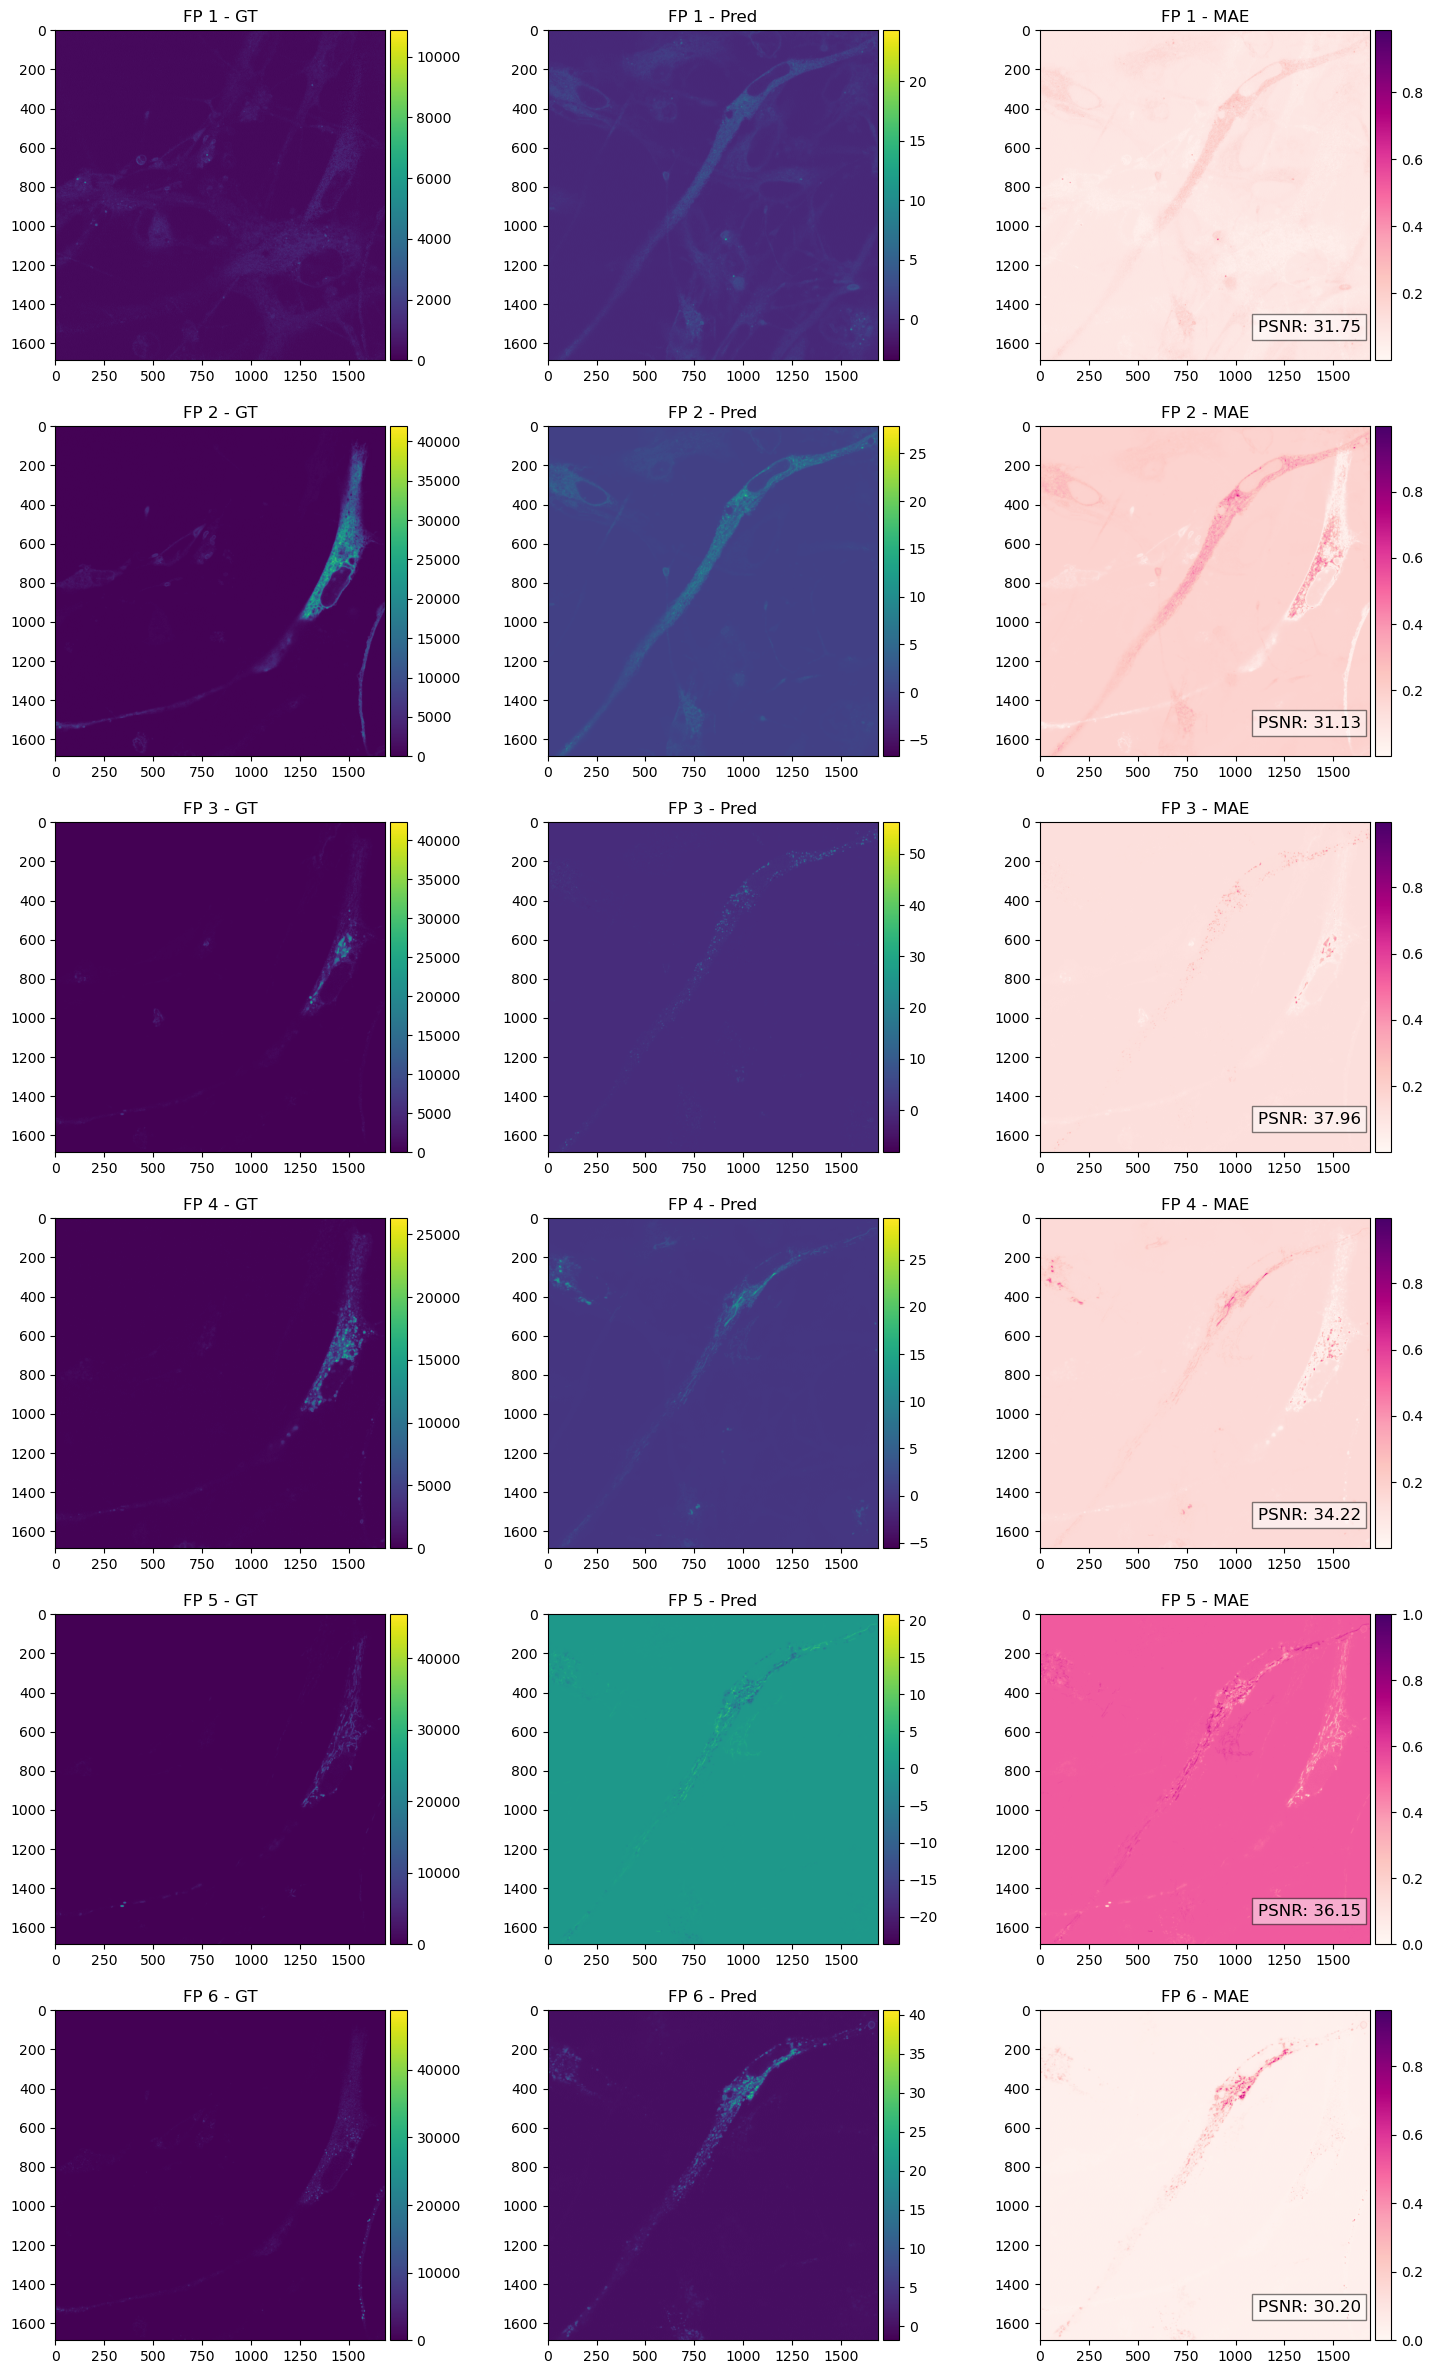

In [31]:
plot_splitting_results(pred_imgs, gt_data, idx=0, preds_std=None)

In [ ]:
view3D(
    imgs=[input_data[0], rec_imgs[0]],
    axis=0, 
    titles=["Input", "Reconstruction"], 
    jupyter=True,
    save_path=os.path.join(OUT_ROOT, ckpt_dir, "reconstruction_example.gif")
)

#### 4.3. Predictions Post-processing



#### 4.4. Investigate Intensities and scales of inputs and predictions:

In [ ]:
intensity_histograms(pred_imgs[0], 2.7e4, 7)

In [ ]:
intensity_histograms(pred_imgs.mean(axis=0))

#### 4.5. Compute metrics between predicted data and high-SNR (ground truth) data

In [ ]:
from careamics.utils.metrics import avg_range_inv_psnr

Prepare data:
- Unnormalize predictions (?) --> check what's the range of the predicted images

NOTE: but actually we don't have access to the stats for the output since the algorithm is **unsupervised**. However, we can still have a look to the ground truth.

In [ ]:
# In case it's needed
gt_mean = gt_data.mean(axis=(0,2,3), keepdims=True)
gt_std = gt_data.std(axis=(0,2,3), keepdims=True)
unnorm_pred_imgs = pred_imgs * gt_std + gt_mean

Compute metrics:

In [ ]:
print("Model's outputs")
print("---------------")
psnr_arr = []
for i in range(pred_imgs.shape[1]):
    psnr_arr.append(avg_range_inv_psnr(pred_imgs[:, i], gt_data[:, i]))
    print(f"Range-Invariant PSNR for FP#{i+1}: {psnr_arr[-1]:.2f}")
print(f"Avg Range-Invariant PSNR: {np.mean(psnr_arr):.2f}")
print(f"Combined Range-Invariant PSNR: {avg_range_inv_psnr(pred_imgs, gt_data):.2f}")

#### 5. Analyses

In [ ]:
model = light_model.model
mixer = model.mixer
ref_matrix = mixer.ref_matrix.cpu().detach().numpy()
ref_matrix.shape

In [ ]:
# plot the reference matrix
for i in range(ref_matrix.shape[1]):
    plt.plot(ref_matrix[:, i], label=f"FP{i+1}")
    plt.legend()

In [ ]:
unmixed = torch.tensor(gt_data[0], dtype=torch.float32).unsqueeze(0).cuda()

In [ ]:
rec = mixer(unmixed).squeeze()

In [ ]:
_, ax = plt.subplots(1, 3, figsize=(18, 5))

rec_means = rec.mean(dim=(1, 2))
ax[0].bar(range(32), rec_means.cpu().detach().numpy())
ax[0].set_title("Rec mean intensities per channel")

inp_means = input_data[0].mean(axis=(1, 2))
ax[1].bar(range(32), inp_means)
ax[1].set_title("Input mean intensities per channel")

mat_means = ref_matrix.mean(axis=1)
ax[2].bar(range(32), mat_means)
ax[2].set_title("Mixing matrix intensities per channel")

In [ ]:
plt.plot(ref_matrix[:, 0], c="blue")
plt.plot(ref_matrix[:, 1], c="green")
plt.plot(ref_matrix[:, 2], c="red")

Try new spectral mixer

In [ ]:
from careamics.utils.spectral import FPRefMatrix, Spectrum

In [ ]:
spec = Spectrum.from_fpbase("EGFP")

In [ ]:
binned = spec.bin_intensity(32, (460, 550))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(spec.intensity, c="r")
plt.plot(binned)

In [ ]:
fp_matrix = FPRefMatrix(
    fp_names=model.fluorophores,
    n_bins=32,
    interval=(460, 550),
)
mat = fp_matrix.create()

In [ ]:
plt.plot(mat[:, 0], c="blue")
plt.plot(mat[:, 1], c="green")
plt.plot(mat[:, 2], c="red")